Please upload your CSV file.


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (8).csv
Loaded equipment_degradation_timeseries_forecasting_dataset (8).csv, shape=(5000, 4)
Detected target series: ['ds1_observed', 'ds2_observed', 'ds3_observed']

==================== Dataset: ds1_observed ====================
Naive  | MAE=0.0673 RMSE=0.0841 R2=0.7467
HGBR  | MAE=0.1174 RMSE=0.1510 R2=0.1827


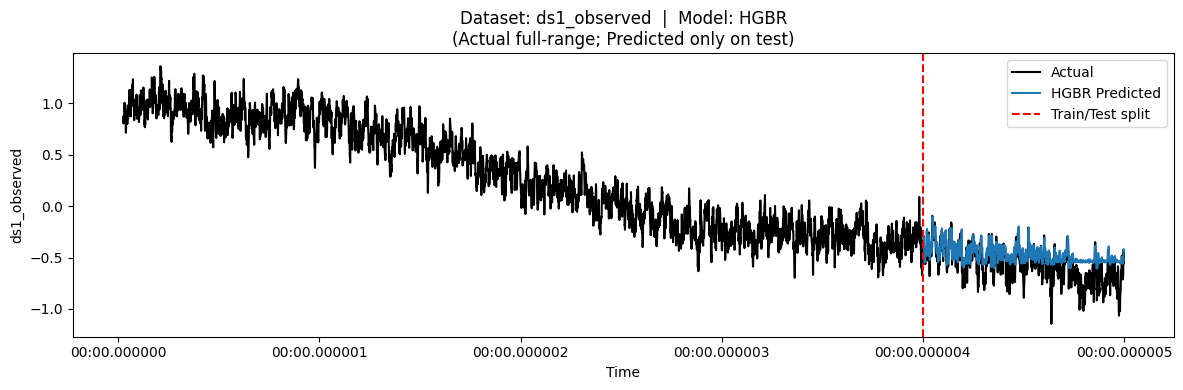

RF    | MAE=0.1294 RMSE=0.1672 R2=-0.0013


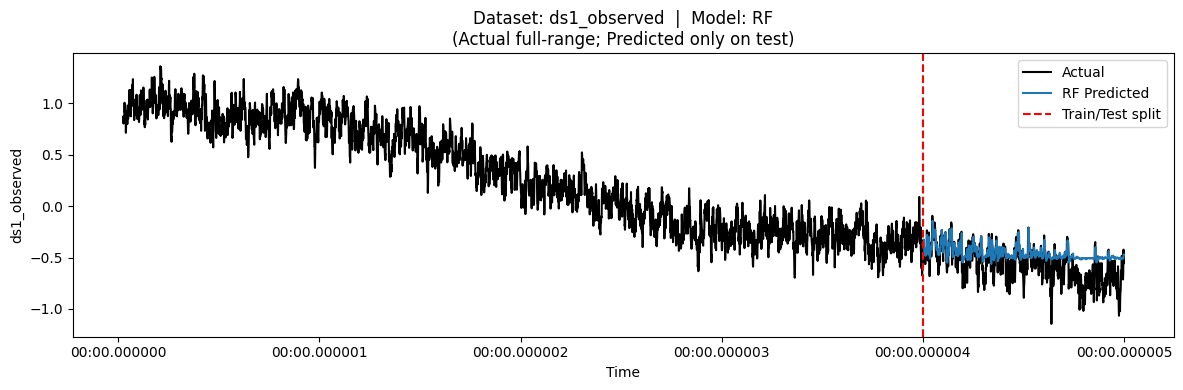

SVR   | MAE=0.1321 RMSE=0.1700 R2=-0.0357


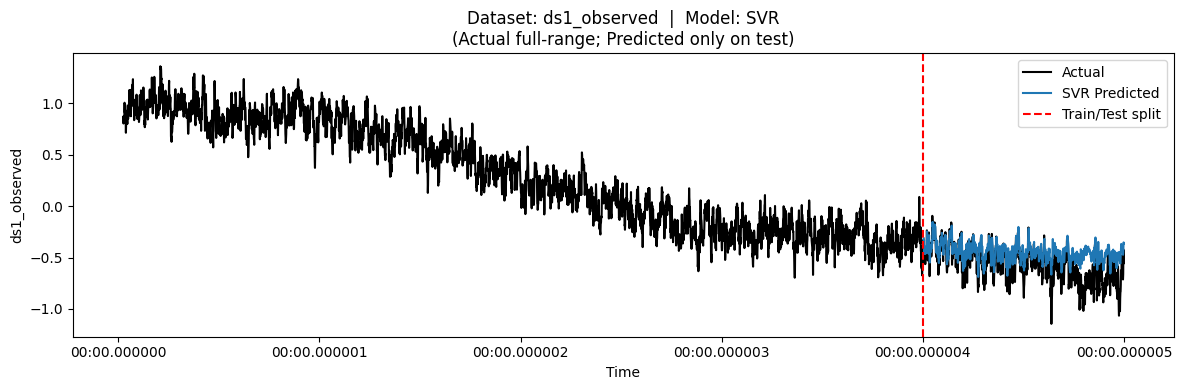

ENet  | MAE=0.0648 RMSE=0.0815 R2=0.7617


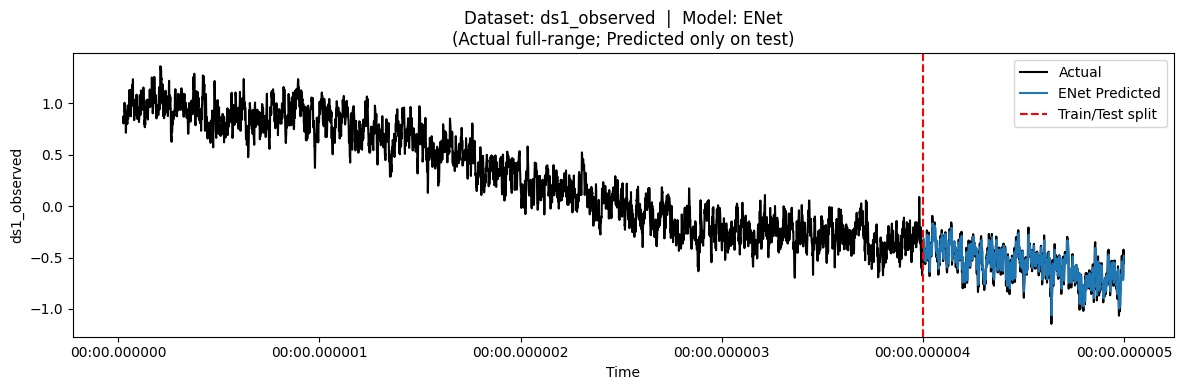


==================== Dataset: ds2_observed ====================
Naive  | MAE=0.1450 RMSE=0.1836 R2=-0.5858
HGBR  | MAE=0.1161 RMSE=0.1452 R2=0.0080


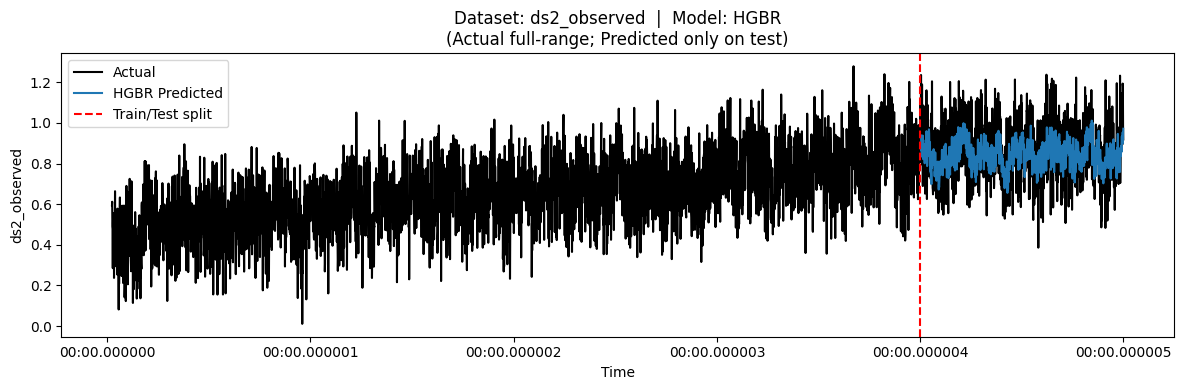

RF    | MAE=0.1158 RMSE=0.1448 R2=0.0138


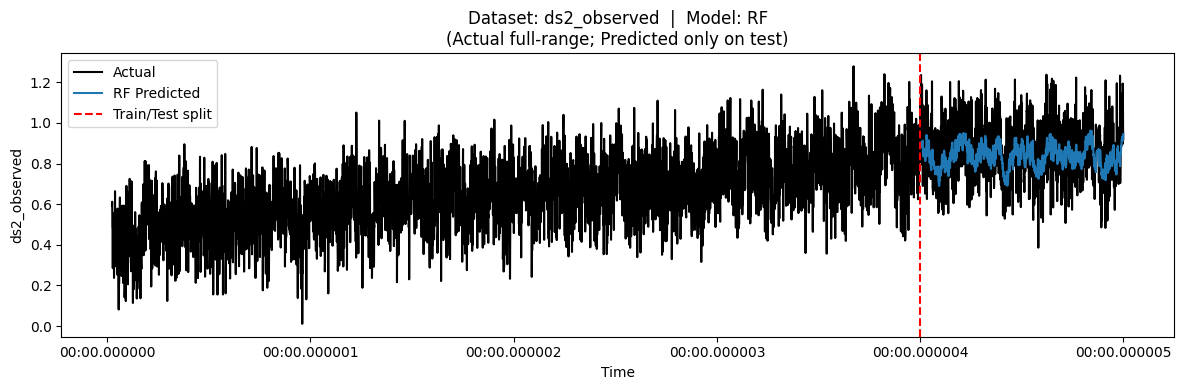

SVR   | MAE=0.1179 RMSE=0.1466 R2=-0.0115


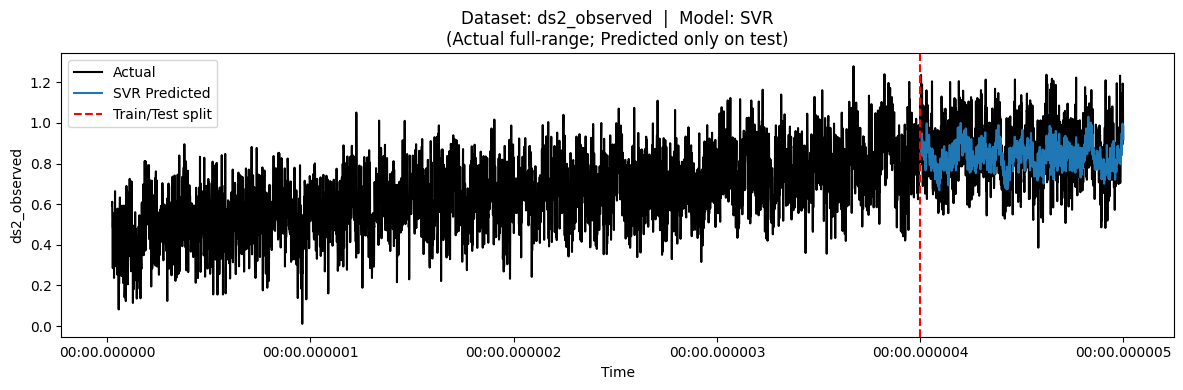

ENet  | MAE=0.1140 RMSE=0.1425 R2=0.0441


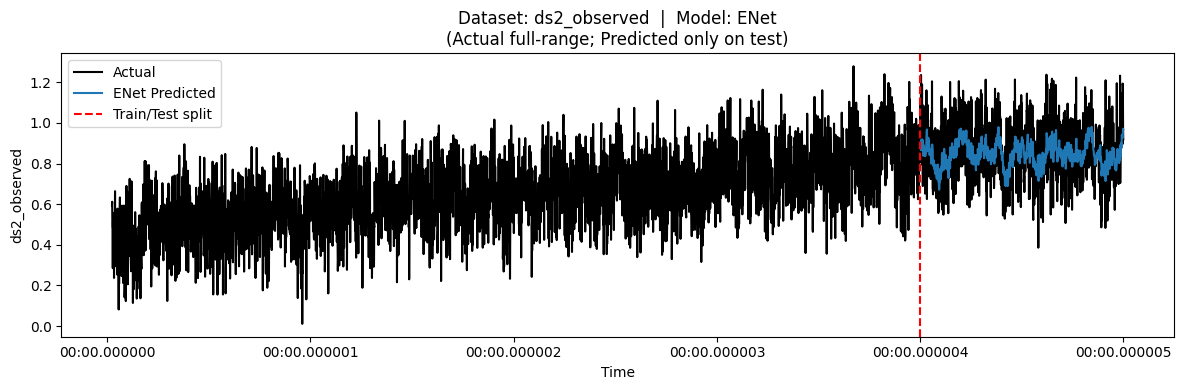


==================== Dataset: ds3_observed ====================
Naive  | MAE=0.1064 RMSE=0.1345 R2=0.0360
HGBR  | MAE=0.1089 RMSE=0.1373 R2=-0.0052


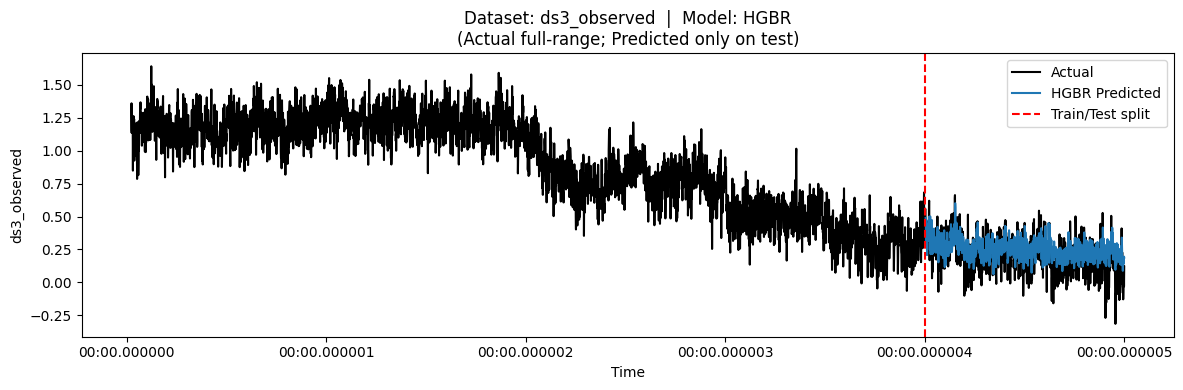

RF    | MAE=0.1019 RMSE=0.1305 R2=0.0915


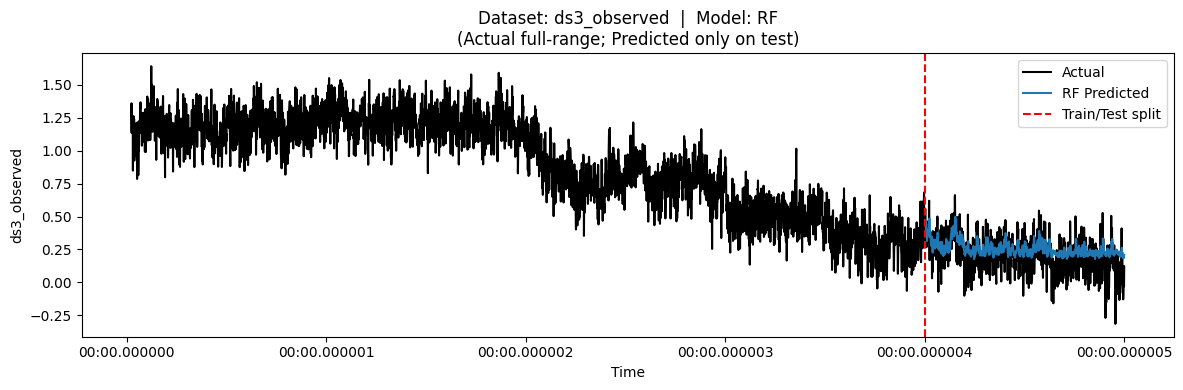

SVR   | MAE=0.0984 RMSE=0.1262 R2=0.1504


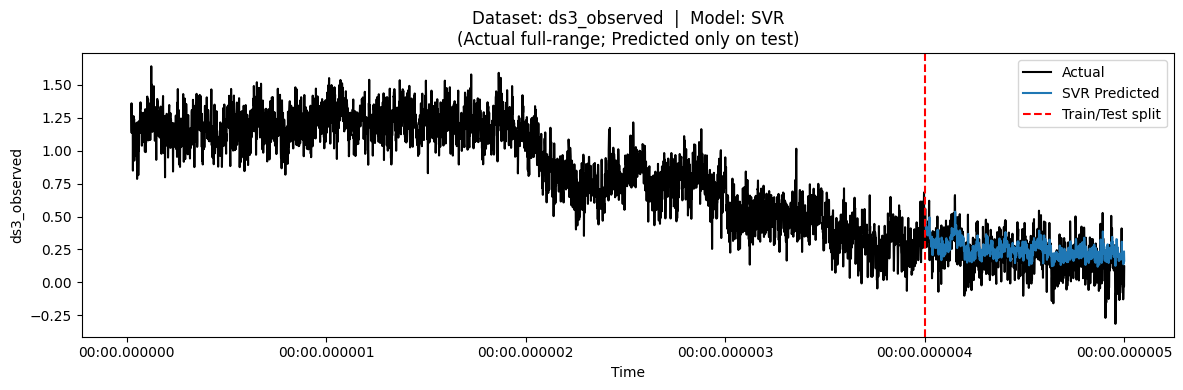

ENet  | MAE=0.0880 RMSE=0.1129 R2=0.3207


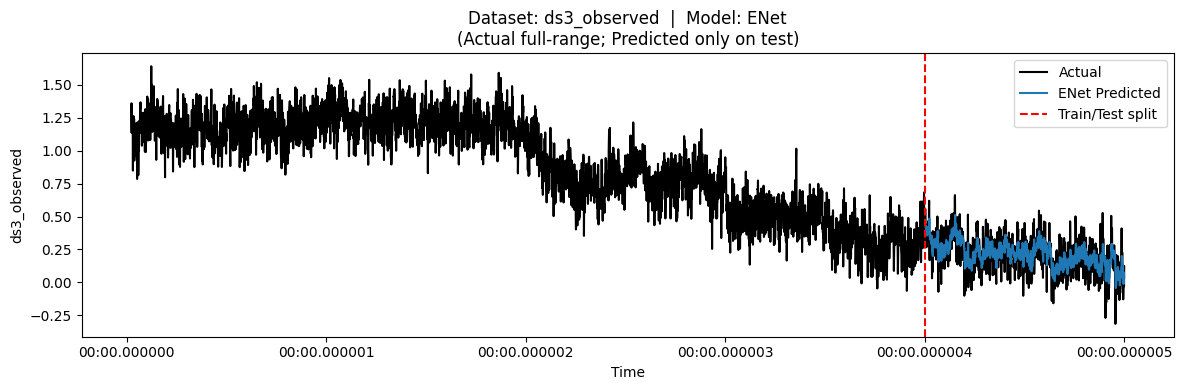


=== Summary: MAE / RMSE / R² for all datasets & models ===


,dataset,model,MAE,RMSE,R2
0,ds1_observed,ENet,0.064834,0.081548,0.761700
1,ds1_observed,Naive,0.067324,0.084076,0.746693
2,ds1_observed,HGBR,0.117397,0.151018,0.182750
3,ds1_observed,RF,0.129380,0.167161,-0.001303
4,ds1_observed,SVR,0.132069,0.170009,-0.035717
5,ds2_observed,ENet,0.113995,0.142527,0.044142
6,ds2_observed,RF,0.115790,0.144773,0.013791
7,ds2_observed,HGBR,0.116074,0.145194,0.008042
8,ds2_observed,SVR,0.117908,0.146619,-0.011524
9,ds2_observed,Naive,0.145036,0.183578,-0.585757


In [ ]:
# %% [colab]
# ==========================================
# ML Forecasting on multiple targets (no future prediction)
# - Full-range Actual curve
# - Predicted curve ONLY on test range
# - One figure per (dataset, model)
# - Summary table of MAE / RMSE / R2 for all
# ==========================================

import io, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from google.colab import files
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# -------- CONFIG --------
CONFIG = {
    "TIME_COL": None,        # e.g. "time" / "date" / "ds"  (None = auto-detect)
    "TARGET_COLS": None,     # e.g. ["ds1_observed","ds2_observed","ds3_observed"] (None = auto all numeric except time)
    "MAX_LAG": 24,
    "ROLLING_WINDOWS": [3,7,14],
    "TRAIN_RATIO": 0.8,      # time-ordered split
    "CV_SPLITS": 5,
    "SEED": 42,
}
np.random.seed(CONFIG["SEED"])

# -------- Upload CSV --------
print("Please upload your CSV file.")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")
csv_name = list(uploaded.keys())[0]
raw = pd.read_csv(io.BytesIO(uploaded[csv_name]))
print(f"Loaded {csv_name}, shape={raw.shape}")

# -------- Time column detection --------
def guess_time_col(df):
    # common names
    for c in df.columns:
        cl = c.lower()
        if cl in ["time","date","datetime","ds","timestamp"]:
            return c
    # try parseable column
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors="coerce")
            if parsed.notna().mean() > 0.7:
                return c
        except Exception:
            pass
    return None

time_col = CONFIG["TIME_COL"] or guess_time_col(raw)
if time_col is None:
    print("(!) No time-like column detected; using integer index for plotting.")
    raw = raw.reset_index().rename(columns={"index": "seq_index"})
    time_col = "seq_index"

df = raw.copy()
if time_col != "seq_index":
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

# -------- Target columns detection --------
if CONFIG["TARGET_COLS"] is None:
    targets = [c for c in df.select_dtypes(include=[np.number]).columns if c != time_col]
else:
    targets = CONFIG["TARGET_COLS"]

if len(targets) == 0:
    raise ValueError("No numeric target columns found. Set CONFIG['TARGET_COLS'].")

print("Detected target series:", targets)

# -------- Feature engineering (per target) --------
def make_features(df, time_col, target, max_lag, roll_ws):
    d = df[[time_col, target]].copy()
    # lags
    for lag in range(1, max_lag+1):
        d[f"{target}_lag{lag}"] = d[target].shift(lag)
    # rolling (shifted by 1 to prevent leakage)
    for w in roll_ws:
        d[f"{target}_rollmean_{w}"] = d[target].shift(1).rolling(w).mean()
        d[f"{target}_rollstd_{w}"]  = d[target].shift(1).rolling(w).std()
        d[f"{target}_rollmin_{w}"]  = d[target].shift(1).rolling(w).min()
        d[f"{target}_rollmax_{w}"]  = d[target].shift(1).rolling(w).max()
    # simple calendar/cyclical features (if time is datetime)
    if np.issubdtype(d[time_col].dtype, np.datetime64):
        dt = d[time_col]
        d["dow"] = dt.dt.dayofweek
        d["hour"] = dt.dt.hour
        d["dow_sin"] = np.sin(2*np.pi*d["dow"]/7)
        d["dow_cos"] = np.cos(2*np.pi*d["dow"]/7)
        d["hour_sin"] = np.sin(2*np.pi*d["hour"]/24)
        d["hour_cos"] = np.cos(2*np.pi*d["hour"]/24)
    else:
        # index-based cyclic proxies to avoid dtype issues
        idx = np.arange(len(d))
        d["idx_sin"] = np.sin(2*np.pi*idx/max(24, len(d)))
        d["idx_cos"] = np.cos(2*np.pi*idx/max(24, len(d)))
    return d.dropna().reset_index(drop=True)

# -------- Models --------
def get_models(X_cols):
    scaler = ColumnTransformer([("num", StandardScaler(with_mean=False), X_cols)], remainder="drop")
    return {
        "HGBR": Pipeline([("model", HistGradientBoostingRegressor(random_state=CONFIG["SEED"]))]),
        "RF":   Pipeline([("model", RandomForestRegressor(n_estimators=300, random_state=CONFIG["SEED"], n_jobs=-1))]),
        "SVR":  Pipeline([("scaler", scaler), ("model", SVR())]),
        "ENet": Pipeline([("scaler", scaler), ("model", ElasticNet(random_state=CONFIG["SEED"]))]),
    }

param_spaces = {
    "HGBR": {"model__max_depth":[None,6,10], "model__learning_rate":[0.05,0.1,0.2], "model__max_iter":[200,400]},
    "RF":   {"model__max_depth":[None,8,12], "model__min_samples_split":[2,5], "model__max_features":["sqrt","log2"]},
    "SVR":  {"model__C":[0.5,1,2], "model__epsilon":[0.05,0.1], "model__kernel":["rbf"]},
    "ENet": {"model__alpha":np.logspace(-3,1,4), "model__l1_ratio":[0.2,0.5,0.8], "model__max_iter":[2000]},
}

def rmse(a,b): return math.sqrt(mean_squared_error(a,b))

# -------- Collect metrics for summary table --------
metrics_rows = []

# -------- Main loop: each target --------
for target in targets:
    print(f"\n==================== Dataset: {target} ====================")
    d = make_features(df, time_col, target, CONFIG["MAX_LAG"], CONFIG["ROLLING_WINDOWS"])
    X_cols = [c for c in d.columns if c not in [time_col, target]]

    # time-ordered split
    n = len(d)
    split = int(n * CONFIG["TRAIN_RATIO"])
    train, test = d.iloc[:split], d.iloc[split:]
    X_train, y_train = train[X_cols], train[target]
    X_test,  y_test  = test[X_cols],  test[target]

    # time vectors for plotting
    t_all = d[time_col].values
    t_train = train[time_col].values
    t_test  = test[time_col].values
    split_time = test[time_col].iloc[0]  # vertical line

    # ----- Naive baseline (y_t ≈ y_{t-1})
    naive_pred = test[f"{target}_lag1"].values
    naive_mae  = mean_absolute_error(y_test, naive_pred)
    naive_rmse = rmse(y_test, naive_pred)
    naive_r2   = r2_score(y_test, naive_pred)
    print(f"Naive  | MAE={naive_mae:.4f} RMSE={naive_rmse:.4f} R2={naive_r2:.4f}")
    metrics_rows.append({"dataset": target, "model": "Naive",
                         "MAE": naive_mae, "RMSE": naive_rmse, "R2": naive_r2})

    # ----- ML models with TimeSeries CV
    models = get_models(X_cols)
    tscv = TimeSeriesSplit(n_splits=CONFIG["CV_SPLITS"])

    for name, pipe in models.items():
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_spaces[name],
            n_iter=6,
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
            random_state=CONFIG["SEED"],
            refit=True
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        pred = model.predict(X_test)

        mae  = mean_absolute_error(y_test, pred)
        rmse_ = rmse(y_test, pred)
        r2   = r2_score(y_test, pred)
        print(f"{name:5s} | MAE={mae:.4f} RMSE={rmse_:.4f} R2={r2:.4f}")

        metrics_rows.append({"dataset": target, "model": name,
                             "MAE": mae, "RMSE": rmse_, "R2": r2})

        # ----- Plot: full-range Actual + predicted ONLY on test range -----
        plt.figure(figsize=(12,4))
        # full actual
        plt.plot(t_all, d[target].values, label="Actual", color="black", linewidth=1.5)
        # predicted only on test interval
        plt.plot(t_test, pred, label=f"{name} Predicted", linewidth=1.5)
        # vertical split line
        plt.axvline(split_time, color="red", linestyle="--", label="Train/Test split")
        plt.title(f"Dataset: {target}  |  Model: {name}\n(Actual full-range; Predicted only on test)")
        plt.xlabel("Time"); plt.ylabel(target); plt.legend(); plt.tight_layout(); plt.show()

# -------- Summary table --------
summary_df = pd.DataFrame(metrics_rows)
# Optional: sort by dataset then RMSE
summary_df = summary_df.sort_values(by=["dataset","RMSE"]).reset_index(drop=True)

print("\n=== Summary: MAE / RMSE / R² for all datasets & models ===")
display(summary_df)

Please upload your CSV file.


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (9).csv
Loaded equipment_degradation_timeseries_forecasting_dataset (9).csv, shape=(5000, 4)
Detected target series: ['ds1_observed', 'ds2_observed', 'ds3_observed']

==================== Dataset: ds1_observed ====================
STL period used: 60
Naive  | MAE=0.0447 RMSE=0.0624 R2=0.7708
HGBR  | MAE=0.1426 RMSE=0.1794 R2=-0.8932


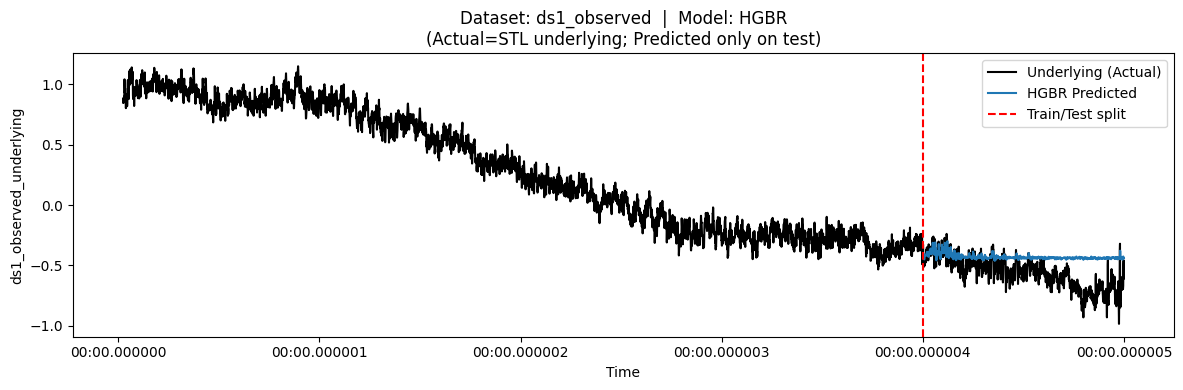

RF    | MAE=0.1410 RMSE=0.1781 R2=-0.8662


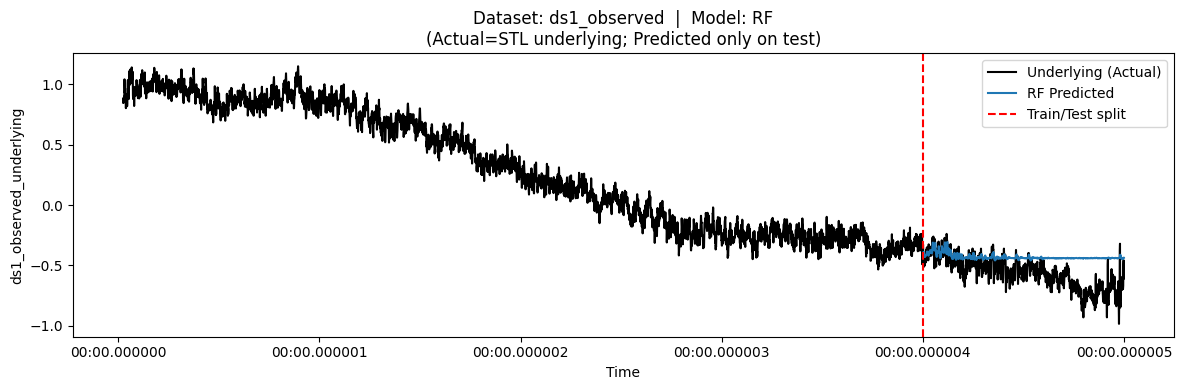

SVR   | MAE=0.1075 RMSE=0.1638 R2=-0.5794


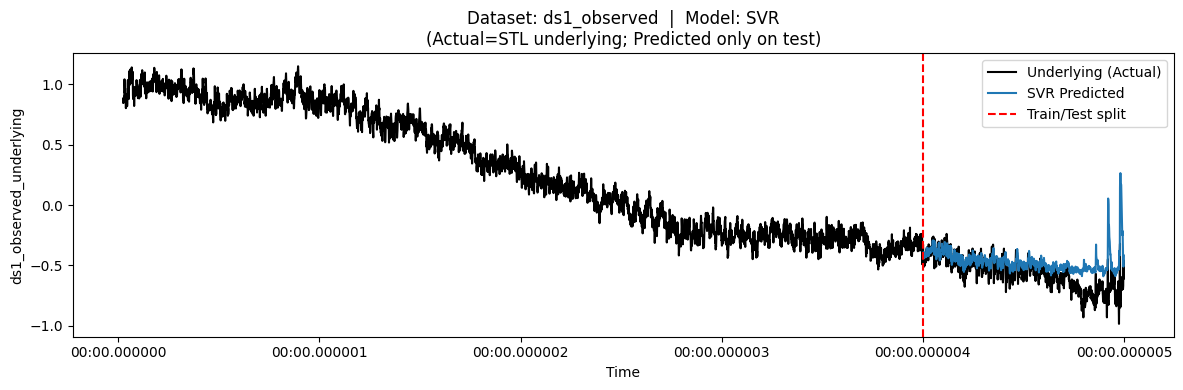

ENet  | MAE=0.0421 RMSE=0.0579 R2=0.8025


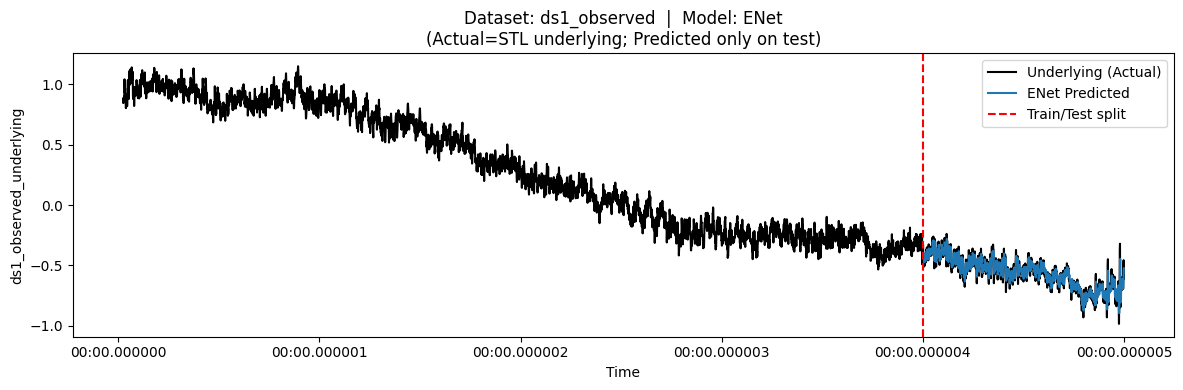


==================== Dataset: ds2_observed ====================
STL period used: 9
Naive  | MAE=0.0778 RMSE=0.0998 R2=-0.0480
HGBR  | MAE=0.0399 RMSE=0.0503 R2=0.7334


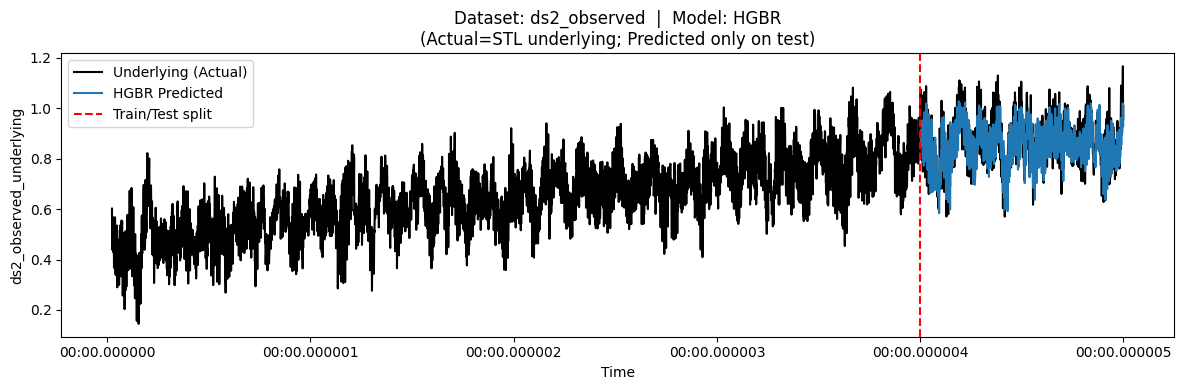

RF    | MAE=0.0518 RMSE=0.0653 R2=0.5517


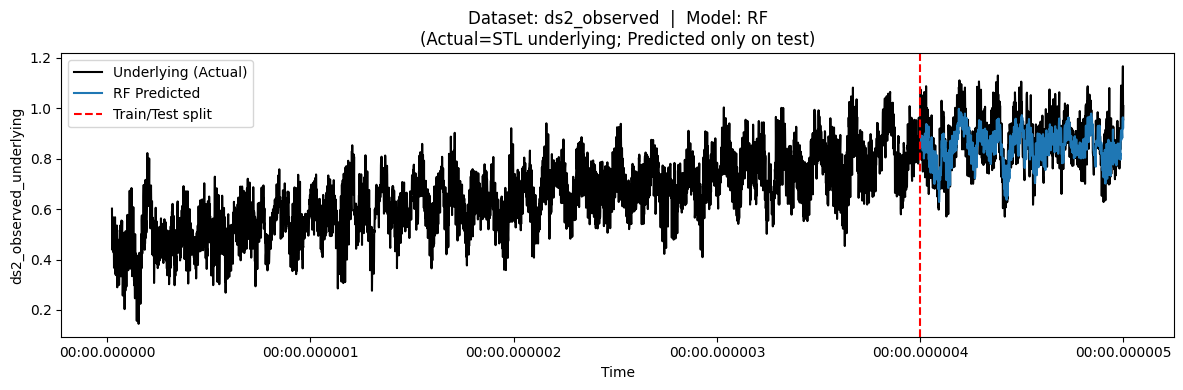

SVR   | MAE=0.0322 RMSE=0.0404 R2=0.8280


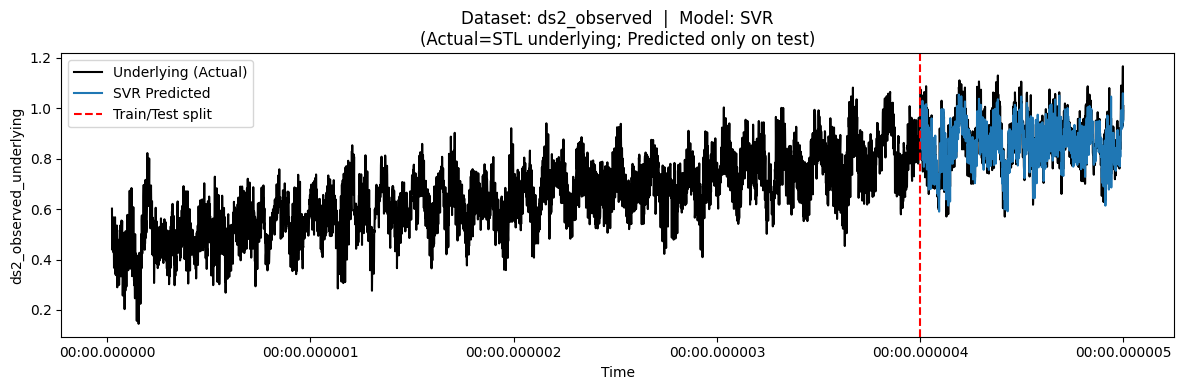

ENet  | MAE=0.0253 RMSE=0.0326 R2=0.8883


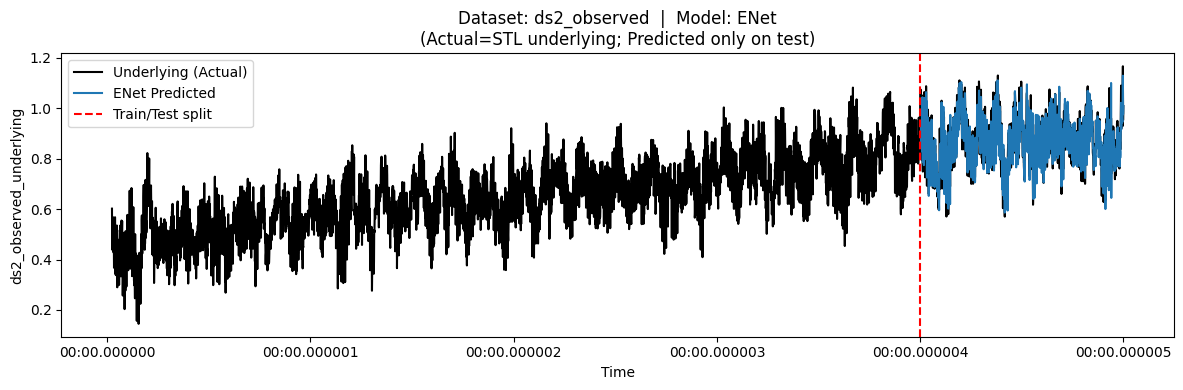


==================== Dataset: ds3_observed ====================
STL period used: 8
Naive  | MAE=0.0550 RMSE=0.0688 R2=0.5466
HGBR  | MAE=0.0439 RMSE=0.0576 R2=0.6829


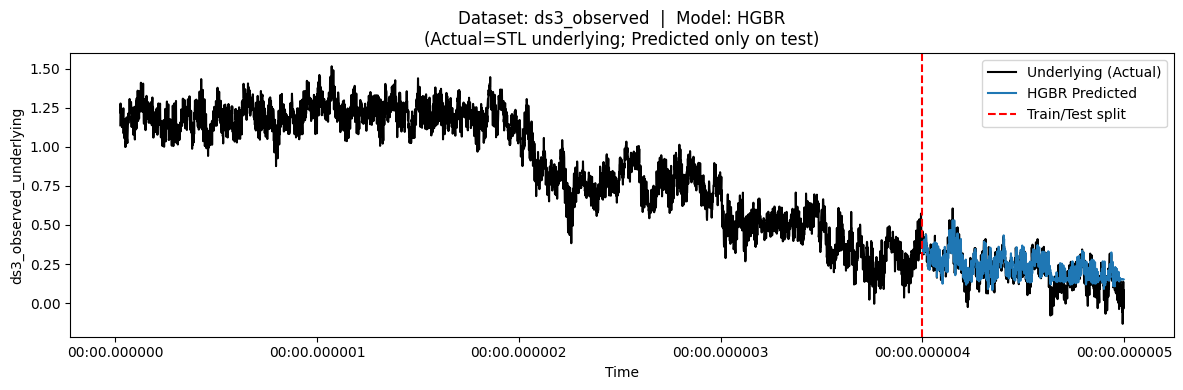

RF    | MAE=0.0543 RMSE=0.0694 R2=0.5386


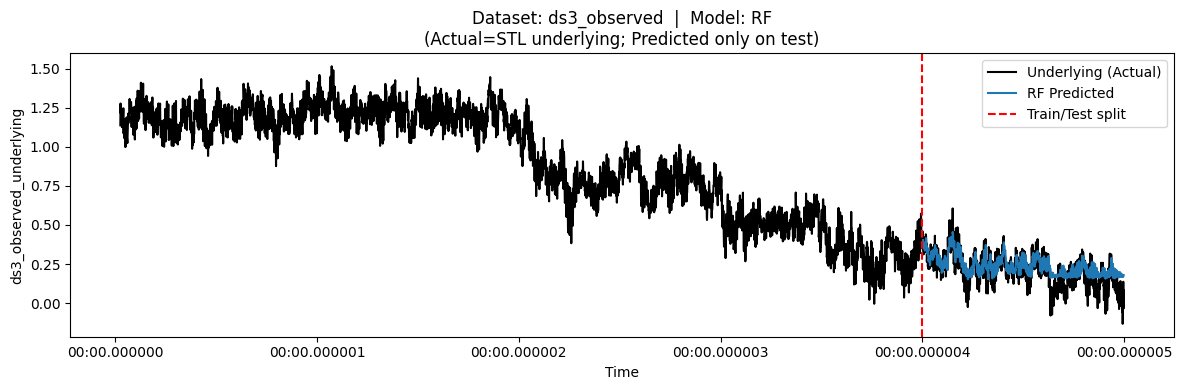

SVR   | MAE=0.0350 RMSE=0.0454 R2=0.8028


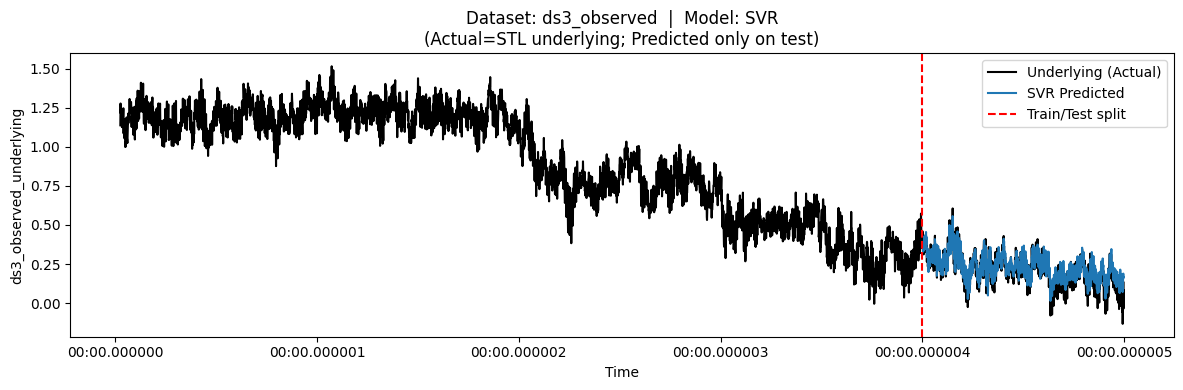

ENet  | MAE=0.0232 RMSE=0.0292 R2=0.9184


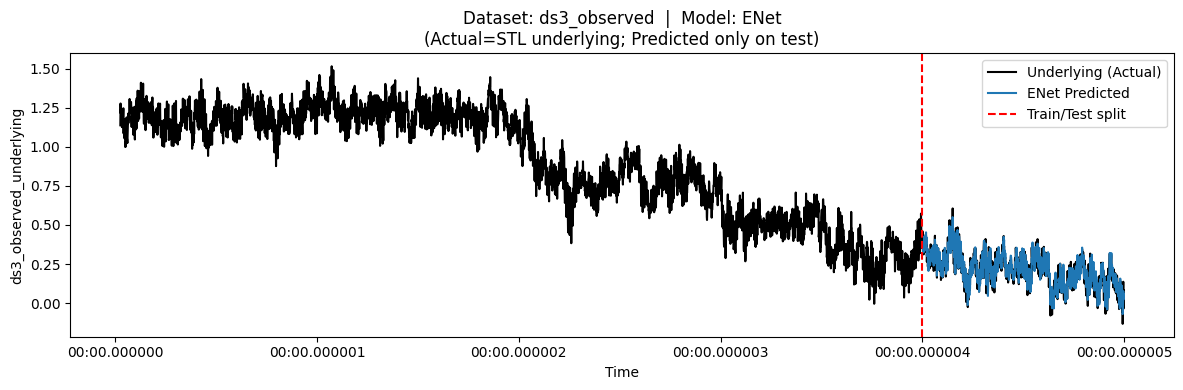


=== Summary: MAE / RMSE / R² on STL-underlying (all datasets & models) ===


,dataset,model,MAE,RMSE,R2
0,ds1_observed,ENet,0.042092,0.057934,0.802533
1,ds1_observed,Naive,0.044667,0.062411,0.770830
2,ds1_observed,SVR,0.107454,0.163845,-0.579424
3,ds1_observed,RF,0.140961,0.178097,-0.866155
4,ds1_observed,HGBR,0.142642,0.179384,-0.893215
5,ds2_observed,ENet,0.025302,0.032576,0.888317
6,ds2_observed,SVR,0.032228,0.040426,0.828007
7,ds2_observed,HGBR,0.039871,0.050331,0.733401
8,ds2_observed,RF,0.051822,0.065266,0.551703
9,ds2_observed,Naive,0.077764,0.099790,-0.048006


In [ ]:
# %% [colab]
# ==========================================
# ML Forecasting with Preprocessing (STL)
# - Extract underlying signal via STL (auto period)
# - Train/test within existing data only (no future forecast)
# - Plot: full-range underlying (Actual) + Predicted only on test
# - Per (dataset, model) one figure; print summary table
# ==========================================

import io, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from google.colab import files
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

from statsmodels.tsa.seasonal import STL
from scipy.signal import find_peaks

# -------- CONFIG --------
CONFIG = {
    "TIME_COL": None,        # e.g. "time" / "date" / "ds"  (None = auto-detect)
    "TARGET_COLS": None,     # e.g. ["ds1_observed","ds2_observed","ds3_observed"] (None = auto all numeric except time)
    "MAX_LAG": 24,
    "ROLLING_WINDOWS": [3,7,14],
    "TRAIN_RATIO": 0.8,      # time-ordered split
    "CV_SPLITS": 5,
    "SEED": 42,

    # STL params
    "STL_MIN_PERIOD": 5,     # lower bound for seasonal period search
    "STL_MAX_PERIOD": 365,   # upper bound for seasonal period search (cap for speed)
    "STL_DEFAULT_PERIOD": 24 # fallback if not detectable
}
np.random.seed(CONFIG["SEED"])

# -------- Upload CSV --------
print("Please upload your CSV file.")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")
csv_name = list(uploaded.keys())[0]
raw = pd.read_csv(io.BytesIO(uploaded[csv_name]))
print(f"Loaded {csv_name}, shape={raw.shape}")

# -------- Time column detection --------
def guess_time_col(df):
    for c in df.columns:
        cl = c.lower()
        if cl in ["time","date","datetime","ds","timestamp"]:
            return c
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors="coerce")
            if parsed.notna().mean() > 0.7:
                return c
        except Exception:
            pass
    return None

time_col = CONFIG["TIME_COL"] or guess_time_col(raw)
if time_col is None:
    print("(!) No time-like column detected; using integer index for plotting.")
    raw = raw.reset_index().rename(columns={"index": "seq_index"})
    time_col = "seq_index"

df = raw.copy()
if time_col != "seq_index":
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

# -------- Target columns detection --------
if CONFIG["TARGET_COLS"] is None:
    targets = [c for c in df.select_dtypes(include=[np.number]).columns if c != time_col]
else:
    targets = CONFIG["TARGET_COLS"]

if len(targets) == 0:
    raise ValueError("No numeric target columns found. Set CONFIG['TARGET_COLS'].")

print("Detected target series:", targets)

# -------- Utilities --------
def rmse(a,b): return math.sqrt(mean_squared_error(a,b))

def infer_seasonal_period(series, min_p=5, max_p=365):
    """
    Use autocorrelation peak to guess dominant seasonal period (integer).
    """
    x = pd.Series(series).astype(float).values
    x = x - np.nanmean(x)
    n = len(x)
    max_p = int(min(max_p, max(2, n//8)))  # cap by data length
    if max_p <= min_p:
        return None
    # autocorrelation for lags
    acf = np.correlate(x - x.mean(), x - x.mean(), mode='full')[n-1:n-1+max_p+1]
    acf = acf / acf[0]  # normalize
    lags = np.arange(len(acf))
    # ignore lag 0, find peaks in [min_p, max_p]
    acf_seg = acf[min_p:]
    peaks, _ = find_peaks(acf_seg)
    if len(peaks)==0:
        return None
    best_lag = peaks[np.argmax(acf_seg[peaks])] + min_p
    return int(best_lag) if best_lag>=min_p else None

def stl_underlying(series, min_p, max_p, default_p):
    """
    Robust STL to get underlying = trend + seasonal.
    Auto-infer period; fallback to default if needed.
    """
    s = pd.Series(series).astype(float)
    s = s.interpolate(limit_direction="both")
    period = infer_seasonal_period(s.values, min_p, max_p)
    if period is None:
        period = default_p
    period = max(min_p, int(period))
    try:
        res = STL(s, period=period, robust=True).fit()
        return (res.trend + res.seasonal).rename(s.name), period
    except Exception:
        # last resort: simple EWMA smoothing
        ew = s.ewm(span=max(5, period//2), adjust=False).mean()
        return ew.rename(s.name), period

def make_features(df, time_col, target, max_lag, roll_ws):
    """
    Build leakage-free lag/rolling/time features on the (preprocessed) target.
    """
    d = df[[time_col, target]].copy()
    # lags
    for lag in range(1, max_lag+1):
        d[f"{target}_lag{lag}"] = d[target].shift(lag)
    # rolling (shift by 1)
    for w in roll_ws:
        d[f"{target}_rollmean_{w}"] = d[target].shift(1).rolling(w).mean()
        d[f"{target}_rollstd_{w}"]  = d[target].shift(1).rolling(w).std()
        d[f"{target}_rollmin_{w}"]  = d[target].shift(1).rolling(w).min()
        d[f"{target}_rollmax_{w}"]  = d[target].shift(1).rolling(w).max()
    # time/cyclical
    if np.issubdtype(d[time_col].dtype, np.datetime64):
        dt = d[time_col]
        d["dow"] = dt.dt.dayofweek
        d["hour"] = dt.dt.hour
        d["dow_sin"] = np.sin(2*np.pi*d["dow"]/7)
        d["dow_cos"] = np.cos(2*np.pi*d["dow"]/7)
        d["hour_sin"] = np.sin(2*np.pi*d["hour"]/24)
        d["hour_cos"] = np.cos(2*np.pi*d["hour"]/24)
    else:
        idx = np.arange(len(d))
        d["idx_sin"] = np.sin(2*np.pi*idx/max(24, len(d)))
        d["idx_cos"] = np.cos(2*np.pi*idx/max(24, len(d)))
    return d.dropna().reset_index(drop=True)

def get_models(X_cols):
    scaler = ColumnTransformer([("num", StandardScaler(with_mean=False), X_cols)], remainder="drop")
    return {
        "HGBR": Pipeline([("model", HistGradientBoostingRegressor(random_state=CONFIG["SEED"]))]),
        "RF":   Pipeline([("model", RandomForestRegressor(n_estimators=300, random_state=CONFIG["SEED"], n_jobs=-1))]),
        "SVR":  Pipeline([("scaler", scaler), ("model", SVR())]),
        "ENet": Pipeline([("scaler", scaler), ("model", ElasticNet(random_state=CONFIG["SEED"]))]),
    }

param_spaces = {
    "HGBR": {"model__max_depth":[None,6,10], "model__learning_rate":[0.05,0.1,0.2], "model__max_iter":[200,400]},
    "RF":   {"model__max_depth":[None,8,12], "model__min_samples_split":[2,5], "model__max_features":["sqrt","log2"]},
    "SVR":  {"model__C":[0.5,1,2], "model__epsilon":[0.05,0.1], "model__kernel":["rbf"]},
    "ENet": {"model__alpha":np.logspace(-3,1,4), "model__l1_ratio":[0.2,0.5,0.8], "model__max_iter":[2000]},
}

# -------- Collect metrics for summary table --------
metrics_rows = []

# -------- Main loop: each target --------
for target in targets:
    print(f"\n==================== Dataset: {target} ====================")

    # 1) Preprocess to extract underlying signal via STL (auto period)
    underlying, period_used = stl_underlying(
        df[target].values,
        CONFIG["STL_MIN_PERIOD"],
        CONFIG["STL_MAX_PERIOD"],
        CONFIG["STL_DEFAULT_PERIOD"]
    )
    underlying.name = f"{target}_underlying"
    print(f"STL period used: {period_used}")

    # Build a working frame containing time + preprocessed target
    df_u = pd.DataFrame({time_col: df[time_col].values, underlying.name: underlying.values})

    # 2) Feature engineering on underlying signal
    d = make_features(df_u, time_col, underlying.name, CONFIG["MAX_LAG"], CONFIG["ROLLING_WINDOWS"])
    X_cols = [c for c in d.columns if c not in [time_col, underlying.name]]

    # 3) Time-ordered split
    n = len(d)
    split = int(n * CONFIG["TRAIN_RATIO"])
    train, test = d.iloc[:split], d.iloc[split:]
    X_train, y_train = train[X_cols], train[underlying.name]
    X_test,  y_test  = test[X_cols],  test[underlying.name]

    # Time vectors for plotting
    t_all = d[time_col].values
    t_test = test[time_col].values
    split_time = test[time_col].iloc[0]

    # ----- Naive baseline (y_t ≈ y_{t-1})
    naive_pred = test[f"{underlying.name}_lag1"].values
    naive_mae  = mean_absolute_error(y_test, naive_pred)
    naive_rmse = rmse(y_test, naive_pred)
    naive_r2   = r2_score(y_test, naive_pred)
    print(f"Naive  | MAE={naive_mae:.4f} RMSE={naive_rmse:.4f} R2={naive_r2:.4f}")
    metrics_rows.append({"dataset": target, "model": "Naive",
                         "MAE": naive_mae, "RMSE": naive_rmse, "R2": naive_r2})

    # ----- ML models with TimeSeries CV
    models = get_models(X_cols)
    tscv = TimeSeriesSplit(n_splits=CONFIG["CV_SPLITS"])

    for name, pipe in models.items():
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_spaces[name],
            n_iter=6,
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
            random_state=CONFIG["SEED"],
            refit=True
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        pred = model.predict(X_test)

        mae  = mean_absolute_error(y_test, pred)
        rmse_ = rmse(y_test, pred)
        r2   = r2_score(y_test, pred)
        print(f"{name:5s} | MAE={mae:.4f} RMSE={rmse_:.4f} R2={r2:.4f}")

        metrics_rows.append({"dataset": target, "model": name,
                             "MAE": mae, "RMSE": rmse_, "R2": r2})

        # ----- Plot: full-range underlying (Actual) + predicted ONLY on test range -----
        plt.figure(figsize=(12,4))
        # full underlying actual
        plt.plot(t_all, d[underlying.name].values, label="Underlying (Actual)", color="black", linewidth=1.5)
        # predicted only on test interval
        plt.plot(t_test, pred, label=f"{name} Predicted", linewidth=1.5)
        # vertical split line
        plt.axvline(split_time, color="red", linestyle="--", label="Train/Test split")
        plt.title(f"Dataset: {target}  |  Model: {name}\n(Actual=STL underlying; Predicted only on test)")
        plt.xlabel("Time"); plt.ylabel(underlying.name); plt.legend(); plt.tight_layout(); plt.show()

# -------- Summary table --------
summary_df = pd.DataFrame(metrics_rows).sort_values(by=["dataset","RMSE"]).reset_index(drop=True)
print("\n=== Summary: MAE / RMSE / R² on STL-underlying (all datasets & models) ===")
display(summary_df)

# (Optional) save summary
# summary_df.to_csv("forecast_summary_on_STL_underlying.csv", index=False)
# from google.colab import files; files.download("forecast_summary_on_STL_underlying.csv")

Please upload your CSV file.


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (10).csv
Loaded equipment_degradation_timeseries_forecasting_dataset (10).csv, shape=(5000, 4)
Detected target series: ['ds1_observed', 'ds2_observed', 'ds3_observed']

==================== Dataset: ds1_observed ====================
STL period=60, SavGol window=51, poly=3
Naive  | MAE=0.0031 RMSE=0.0039 R2=0.9989
HGBR  | MAE=0.1400 RMSE=0.1768 R2=-1.3142


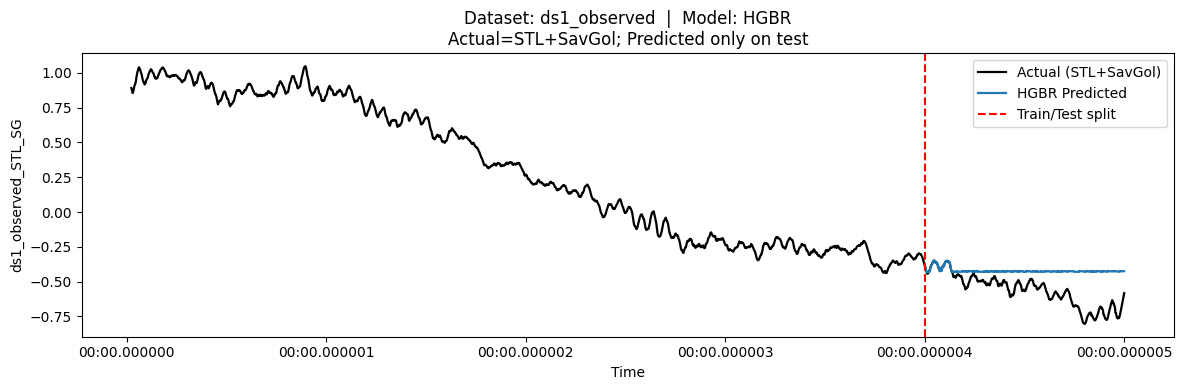

RF    | MAE=0.1436 RMSE=0.1800 R2=-1.3999


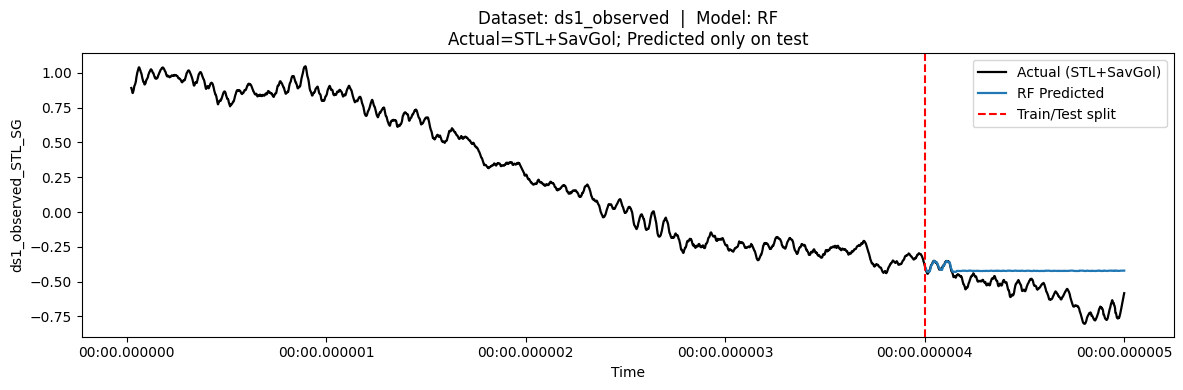

SVR   | MAE=0.1988 RMSE=0.2547 R2=-3.8045


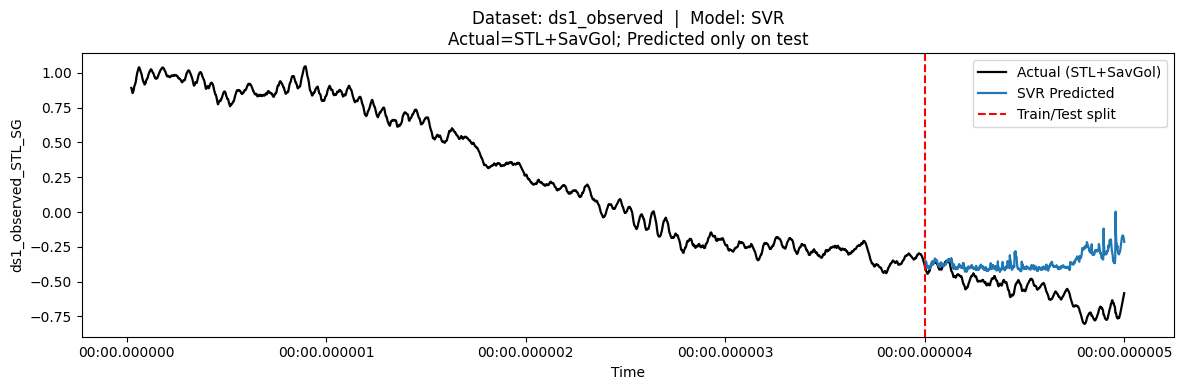

ENet  | MAE=0.0039 RMSE=0.0049 R2=0.9982


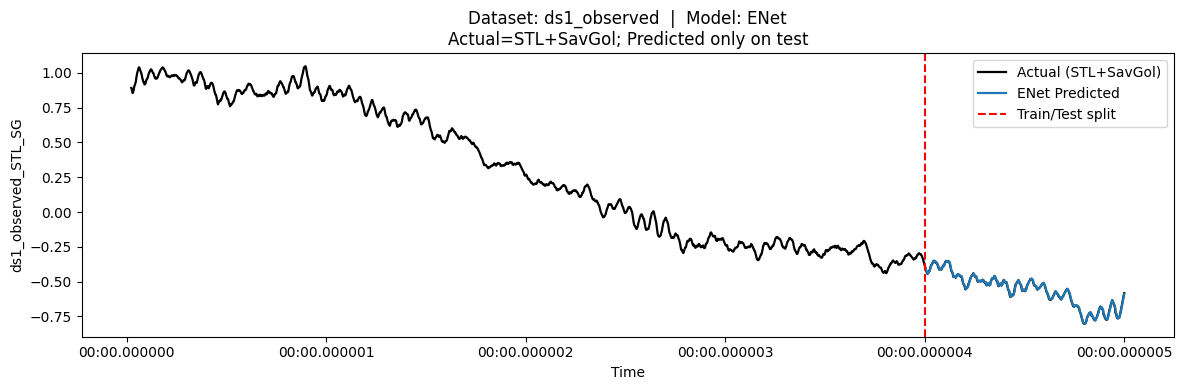


==================== Dataset: ds2_observed ====================
STL period=9, SavGol window=51, poly=3
Naive  | MAE=0.0038 RMSE=0.0048 R2=0.9936
HGBR  | MAE=0.0060 RMSE=0.0101 R2=0.9718


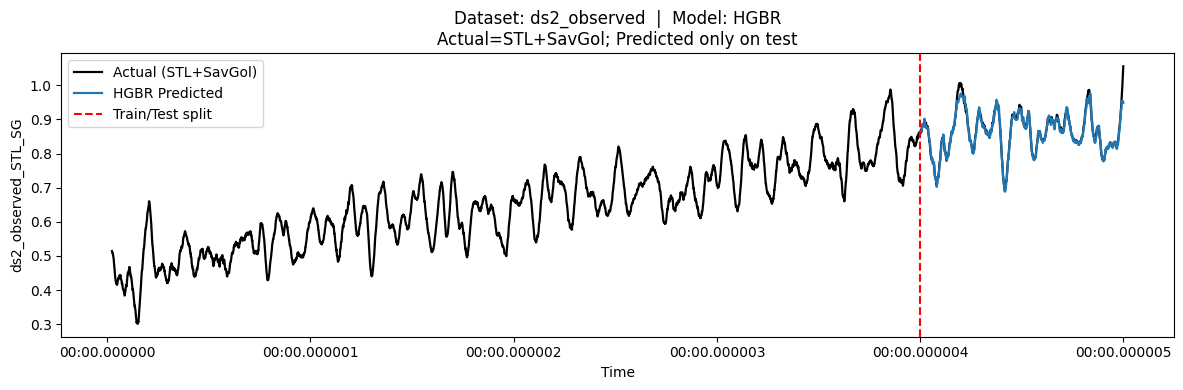

RF    | MAE=0.0067 RMSE=0.0097 R2=0.9739


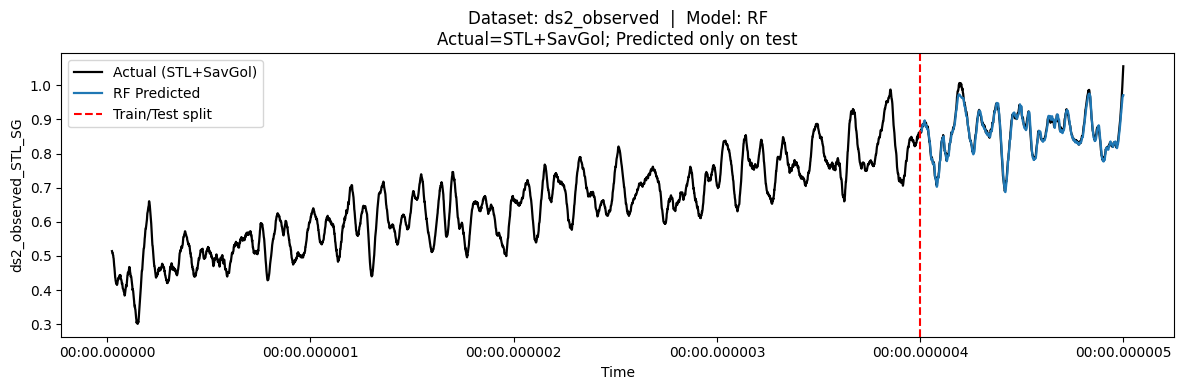

SVR   | MAE=0.0168 RMSE=0.0229 R2=0.8558


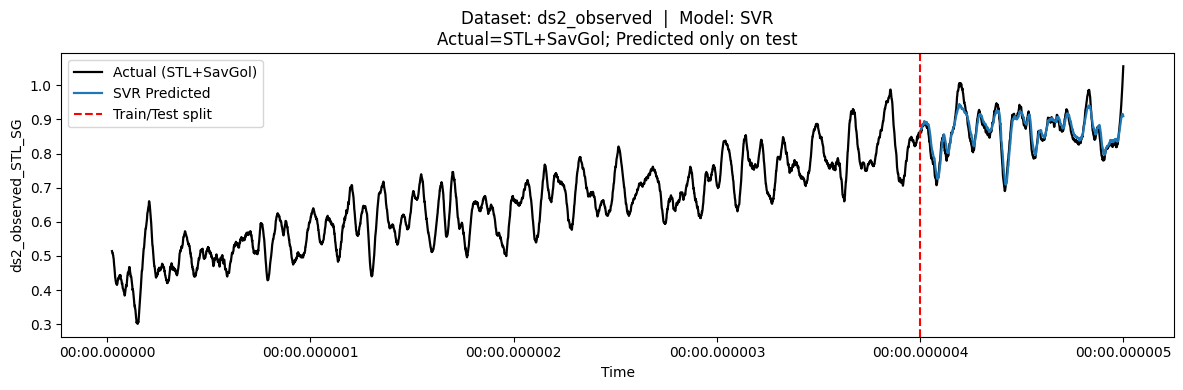

ENet  | MAE=0.0035 RMSE=0.0044 R2=0.9945


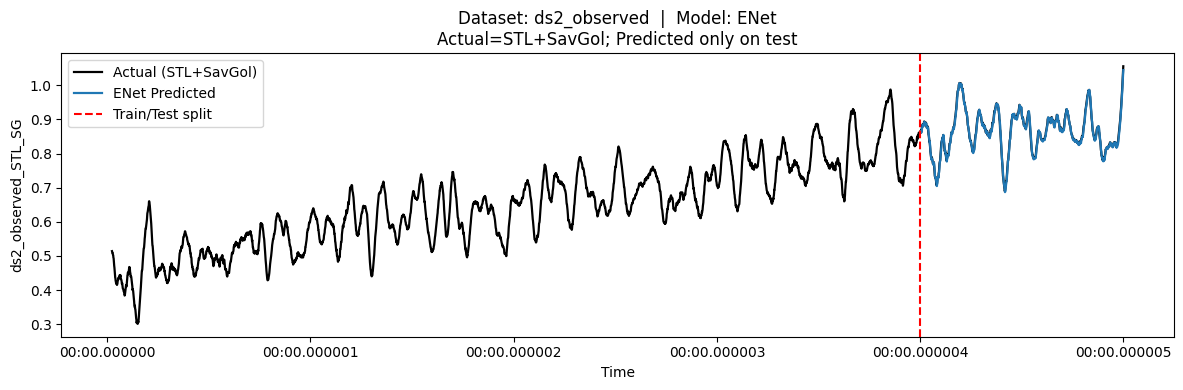


==================== Dataset: ds3_observed ====================
STL period=8, SavGol window=51, poly=3
Naive  | MAE=0.0037 RMSE=0.0046 R2=0.9969
HGBR  | MAE=0.0283 RMSE=0.0487 R2=0.6517


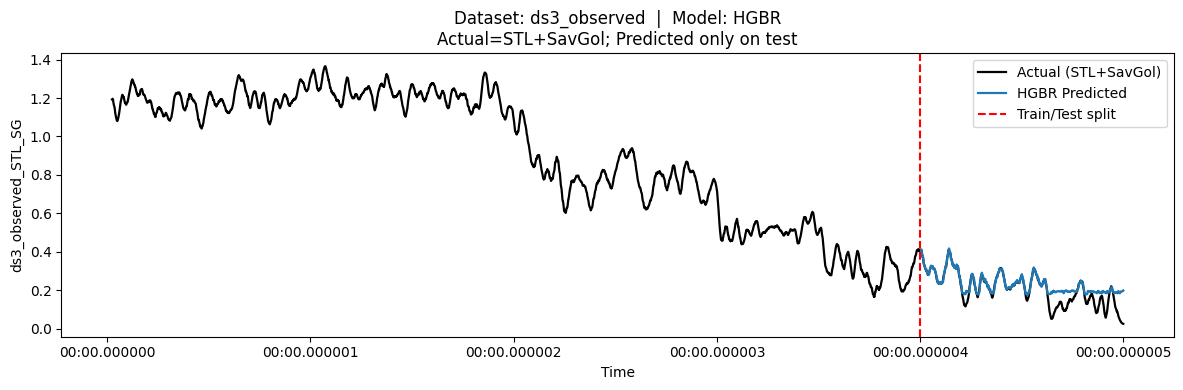

RF    | MAE=0.0275 RMSE=0.0468 R2=0.6782


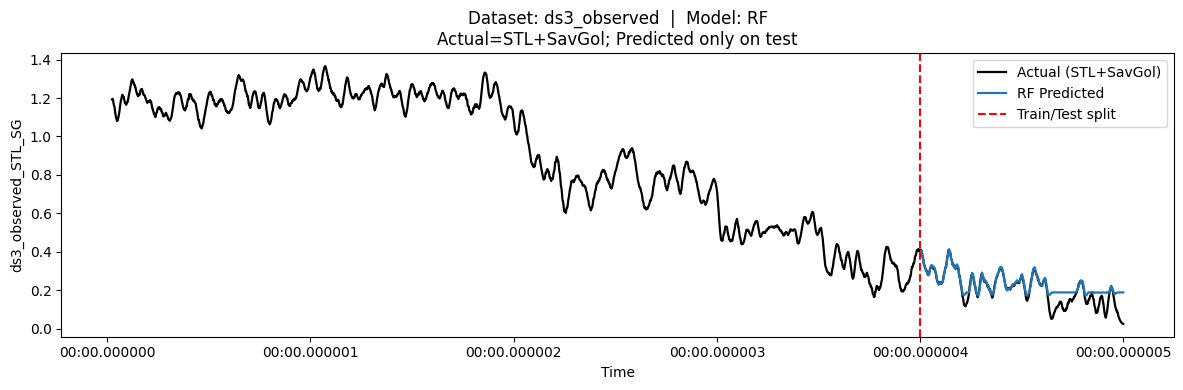

SVR   | MAE=0.0532 RMSE=0.0724 R2=0.2307


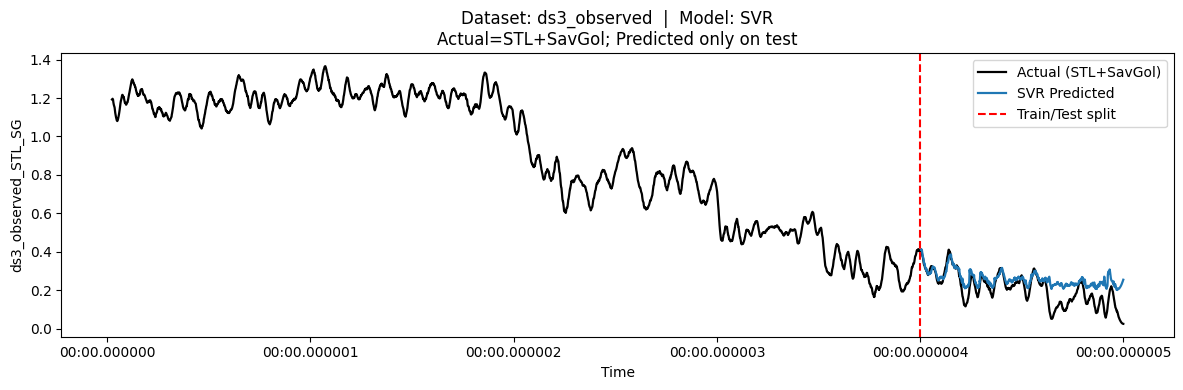

ENet  | MAE=0.0052 RMSE=0.0064 R2=0.9939


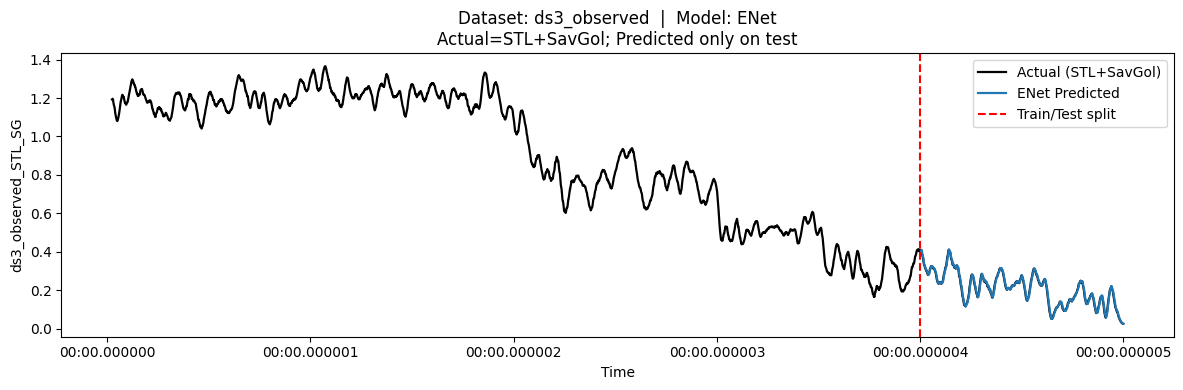


=== Summary (on STL+SavGol underlying): MAE / RMSE / R² ===


,dataset,model,MAE,RMSE,R2
0,ds1_observed,Naive(STL+SG),0.003144,0.003898,0.998875
1,ds1_observed,ENet(STL+SG),0.003897,0.004862,0.998250
2,ds1_observed,HGBR(STL+SG),0.139962,0.176779,-1.314243
3,ds1_observed,RF(STL+SG),0.143584,0.180020,-1.399891
4,ds1_observed,SVR(STL+SG),0.198757,0.254711,-3.804456
5,ds2_observed,ENet(STL+SG),0.003549,0.004449,0.994544
6,ds2_observed,Naive(STL+SG),0.003824,0.004816,0.993608
7,ds2_observed,RF(STL+SG),0.006725,0.009733,0.973891
8,ds2_observed,HGBR(STL+SG),0.005971,0.010107,0.971846
9,ds2_observed,SVR(STL+SG),0.016821,0.022874,0.855806


In [ ]:
# %% [colab]
# ==========================================
# ML Forecasting with Preprocessing: STL + Savitzky-Golay
# - Extract underlying via STL (auto period) -> then smooth with SavGol
# - Train/test only within data range (no future forecast)
# - Plot: full-range (STL+SavGol) Actual + Predicted only on test
# - One figure per (dataset, model) + final summary table
# ==========================================

import io, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from google.colab import files
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

from statsmodels.tsa.seasonal import STL
from scipy.signal import find_peaks, savgol_filter

# -------- CONFIG --------
CONFIG = {
    "TIME_COL": None,        # e.g. "time" / "date" / "ds"  (None = auto-detect)
    "TARGET_COLS": None,     # e.g. ["ds1_observed","ds2_observed","ds3_observed"] (None = all numeric except time)
    "MAX_LAG": 24,
    "ROLLING_WINDOWS": [3,7,14],
    "TRAIN_RATIO": 0.8,      # time-ordered split
    "CV_SPLITS": 5,
    "SEED": 42,

    # STL params
    "STL_MIN_PERIOD": 5,
    "STL_MAX_PERIOD": 365,
    "STL_DEFAULT_PERIOD": 24,

    # Savitzky–Golay params (odd window, >= poly+2; will auto-fix)
    "SAVGOL_WINDOW": 51,
    "SAVGOL_POLY": 3,
}
np.random.seed(CONFIG["SEED"])

# -------- Upload CSV --------
print("Please upload your CSV file.")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")
csv_name = list(uploaded.keys())[0]
raw = pd.read_csv(io.BytesIO(uploaded[csv_name]))
print(f"Loaded {csv_name}, shape={raw.shape}")

# -------- Time column detection --------
def guess_time_col(df):
    for c in df.columns:
        cl = c.lower()
        if cl in ["time","date","datetime","ds","timestamp"]:
            return c
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors="coerce")
            if parsed.notna().mean() > 0.7:
                return c
        except Exception:
            pass
    return None

time_col = CONFIG["TIME_COL"] or guess_time_col(raw)
if time_col is None:
    print("(!) No time-like column detected; using integer index for plotting.")
    raw = raw.reset_index().rename(columns={"index": "seq_index"})
    time_col = "seq_index"

df = raw.copy()
if time_col != "seq_index":
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

# -------- Target columns detection --------
if CONFIG["TARGET_COLS"] is None:
    targets = [c for c in df.select_dtypes(include=[np.number]).columns if c != time_col]
else:
    targets = CONFIG["TARGET_COLS"]

if len(targets) == 0:
    raise ValueError("No numeric target columns found. Set CONFIG['TARGET_COLS'].")

print("Detected target series:", targets)

# -------- Utilities --------
def rmse(a,b): return math.sqrt(mean_squared_error(a,b))

def infer_seasonal_period(series, min_p=5, max_p=365):
    """Guess dominant seasonal period via autocorrelation peaks."""
    x = pd.Series(series).astype(float).values
    x = x - np.nanmean(x)
    n = len(x)
    max_p = int(min(max_p, max(2, n//8)))  # cap by data length
    if max_p <= min_p:
        return None
    acf = np.correlate(x - x.mean(), x - x.mean(), mode='full')[n-1:n-1+max_p+1]
    acf = acf / max(acf[0], 1e-12)
    lags = np.arange(len(acf))
    acf_seg = acf[min_p:]
    peaks, _ = find_peaks(acf_seg)
    if len(peaks)==0:
        return None
    best_lag = peaks[np.argmax(acf_seg[peaks])] + min_p
    return int(best_lag) if best_lag>=min_p else None

def stl_plus_savgol(series, min_p, max_p, default_p, sg_window, sg_poly):
    """
    1) STL to get underlying = trend + seasonal
    2) Savitzky–Golay smoothing on top of STL underlying
    Returns: smoothed_underlying (pd.Series), used_period, used_window, used_poly
    """
    s = pd.Series(series).astype(float)
    s = s.interpolate(limit_direction="both")
    n = len(s)

    # 1) STL period
    period = infer_seasonal_period(s.values, min_p, max_p)
    if period is None:
        period = default_p
    period = max(min_p, int(period))

    # STL decomposition
    try:
        res = STL(s, period=period, robust=True).fit()
        under = (res.trend + res.seasonal)
    except Exception:
        # fallback: EWMA
        under = s.ewm(span=max(5, period//2), adjust=False).mean()

    # 2) SavGol smoothing
    # enforce odd window and within length; window >= poly+2
    window = int(sg_window)
    if window % 2 == 0:
        window += 1
    window = max(window, sg_poly + 2 + (1 - (sg_poly + 2) % 2))  # ensure odd & >= poly+2
    window = min(window, n - (1 - n % 2)) if n > 2 else 1
    window = max(window, 5) if n >= 5 else n  # minimal practical size

    if window < sg_poly + 2:
        sg_poly = max(1, min(2, window - 1))  # adjust poly if needed

    try:
        smoothed = pd.Series(
            savgol_filter(under.values, window_length=window, polyorder=sg_poly, mode="interp"),
            index=s.index, name=s.name
        )
    except Exception:
        smoothed = under

    return smoothed.rename(s.name), period, window, sg_poly

def make_features(df, time_col, target, max_lag, roll_ws):
    """Leakage-free lag/rolling/time features on the (preprocessed) target."""
    d = df[[time_col, target]].copy()
    for lag in range(1, max_lag+1):
        d[f"{target}_lag{lag}"] = d[target].shift(lag)
    for w in roll_ws:
        d[f"{target}_rollmean_{w}"] = d[target].shift(1).rolling(w).mean()
        d[f"{target}_rollstd_{w}"]  = d[target].shift(1).rolling(w).std()
        d[f"{target}_rollmin_{w}"]  = d[target].shift(1).rolling(w).min()
        d[f"{target}_rollmax_{w}"]  = d[target].shift(1).rolling(w).max()
    if np.issubdtype(d[time_col].dtype, np.datetime64):
        dt = d[time_col]
        d["dow"] = dt.dt.dayofweek
        d["hour"] = dt.dt.hour
        d["dow_sin"] = np.sin(2*np.pi*d["dow"]/7)
        d["dow_cos"] = np.cos(2*np.pi*d["dow"]/7)
        d["hour_sin"] = np.sin(2*np.pi*d["hour"]/24)
        d["hour_cos"] = np.cos(2*np.pi*d["hour"]/24)
    else:
        idx = np.arange(len(d))
        d["idx_sin"] = np.sin(2*np.pi*idx/max(24, len(d)))
        d["idx_cos"] = np.cos(2*np.pi*idx/max(24, len(d)))
    return d.dropna().reset_index(drop=True)

def get_models(X_cols):
    scaler = ColumnTransformer([("num", StandardScaler(with_mean=False), X_cols)], remainder="drop")
    return {
        "HGBR": Pipeline([("model", HistGradientBoostingRegressor(random_state=CONFIG["SEED"]))]),
        "RF":   Pipeline([("model", RandomForestRegressor(n_estimators=300, random_state=CONFIG["SEED"], n_jobs=-1))]),
        "SVR":  Pipeline([("scaler", scaler), ("model", SVR())]),
        "ENet": Pipeline([("scaler", scaler), ("model", ElasticNet(random_state=CONFIG["SEED"]))]),
    }

param_spaces = {
    "HGBR": {"model__max_depth":[None,6,10], "model__learning_rate":[0.05,0.1,0.2], "model__max_iter":[200,400]},
    "RF":   {"model__max_depth":[None,8,12], "model__min_samples_split":[2,5], "model__max_features":["sqrt","log2"]},
    "SVR":  {"model__C":[0.5,1,2], "model__epsilon":[0.05,0.1], "model__kernel":["rbf"]},
    "ENet": {"model__alpha":np.logspace(-3,1,4), "model__l1_ratio":[0.2,0.5,0.8], "model__max_iter":[2000]},
}

# -------- Collect metrics for summary table --------
metrics_rows = []

# -------- Main loop: each target --------
for target in targets:
    print(f"\n==================== Dataset: {target} ====================")

    # 1) STL + SavGol 预处理
    pre_name = f"{target}_STL_SG"
    pre_series, period_used, sg_window_used, sg_poly_used = stl_plus_savgol(
        df[target].values,
        CONFIG["STL_MIN_PERIOD"], CONFIG["STL_MAX_PERIOD"], CONFIG["STL_DEFAULT_PERIOD"],
        CONFIG["SAVGOL_WINDOW"], CONFIG["SAVGOL_POLY"]
    )
    pre_series.name = pre_name
    print(f"STL period={period_used}, SavGol window={sg_window_used}, poly={sg_poly_used}")

    # 2) 构建用于特征工程的 DataFrame（时间 + 预处理后的目标）
    df_p = pd.DataFrame({time_col: df[time_col].values, pre_name: pre_series.values})

    # 3) 特征工程（基于 STL+SG 的目标）
    d = make_features(df_p, time_col, pre_name, CONFIG["MAX_LAG"], CONFIG["ROLLING_WINDOWS"])
    X_cols = [c for c in d.columns if c not in [time_col, pre_name]]

    # 4) 时序切分
    n = len(d)
    split = int(n * CONFIG["TRAIN_RATIO"])
    train, test = d.iloc[:split], d.iloc[split:]
    X_train, y_train = train[X_cols], train[pre_name]
    X_test,  y_test  = test[X_cols],  test[pre_name]

    t_all = d[time_col].values
    t_test = test[time_col].values
    split_time = test[time_col].iloc[0]

    # ----- Naive baseline
    naive_pred = test[f"{pre_name}_lag1"].values
    naive_mae  = mean_absolute_error(y_test, naive_pred)
    naive_rmse = rmse(y_test, naive_pred)
    naive_r2   = r2_score(y_test, naive_pred)
    print(f"Naive  | MAE={naive_mae:.4f} RMSE={naive_rmse:.4f} R2={naive_r2:.4f}")
    metrics_rows.append({"dataset": target, "model": "Naive(STL+SG)",
                         "MAE": naive_mae, "RMSE": naive_rmse, "R2": naive_r2})

    # ----- ML models
    models = get_models(X_cols)
    tscv = TimeSeriesSplit(n_splits=CONFIG["CV_SPLITS"])

    for name, pipe in models.items():
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_spaces[name],
            n_iter=6,
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
            random_state=CONFIG["SEED"],
            refit=True
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        pred = model.predict(X_test)

        mae  = mean_absolute_error(y_test, pred)
        rmse_ = rmse(y_test, pred)
        r2   = r2_score(y_test, pred)
        print(f"{name:5s} | MAE={mae:.4f} RMSE={rmse_:.4f} R2={r2:.4f}")

        metrics_rows.append({"dataset": target, "model": f"{name}(STL+SG)",
                             "MAE": mae, "RMSE": rmse_, "R2": r2})

        # ----- 画图：全时段真实(预处理后) + 测试区间预测 -----
        plt.figure(figsize=(12,4))
        plt.plot(t_all, d[pre_name].values, label="Actual (STL+SavGol)", color="black", linewidth=1.6)
        plt.plot(t_test, pred, label=f"{name} Predicted", linewidth=1.6)
        plt.axvline(split_time, color="red", linestyle="--", label="Train/Test split")
        plt.title(f"Dataset: {target}  |  Model: {name}\nActual=STL+SavGol; Predicted only on test")
        plt.xlabel("Time"); plt.ylabel(pre_name); plt.legend(); plt.tight_layout(); plt.show()

# -------- Summary table --------
summary_df = pd.DataFrame(metrics_rows).sort_values(by=["dataset","RMSE"]).reset_index(drop=True)
print("\n=== Summary (on STL+SavGol underlying): MAE / RMSE / R² ===")
display(summary_df)